In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from gensim.models import KeyedVectors
import matplotlib
import matplotlib.pyplot as plt

from models import WordEncoder
from dataset import document_to_flat_feature
from config import (
    BATCH_SIZE,
    DEVICE,
    WORD_HIDDEN_SIZE,
    BIDIRECTIONAL,
    Yelp,
    Yahoo,
    Amazon,
    Synthetic,
)

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = [20, 20]

In [39]:
class Attention(nn.Module):
    def __init__(self, input_size):
        super(Attention, self).__init__()
        self.input_size = input_size
        self.fc = nn.Linear(self.input_size, self.input_size)
        self.context_vector = nn.Parameter(torch.randn(self.input_size))
        self.last_weights = []  # for attention visualization

    def forward(self, input):
        output = torch.tanh(self.fc(input))
        output = torch.matmul(output, self.context_vector)
        output = F.softmax(output, dim=1)
        output = output.permute(1, 0)
        input = input.permute(1, 0, 2)
        batch_size = input.shape[1]
        weighted_sum = torch.zeros(batch_size, self.input_size).to(DEVICE)
        self.last_weights = []
        for alpha, h in zip(output, input):
            self.last_weights.append(alpha.item())
            alpha = alpha.unsqueeze(1).expand_as(h)
            weighted_sum += alpha * h
        return weighted_sum


class Fan(nn.Module):
    "Flat Attention Network"

    def __init__(self, embedding_matrix, word_hidden_size, num_classes, batch_size):
        super(Fan, self).__init__()
        self.word_hidden_size = word_hidden_size
        self.word_encoder = WordEncoder(embedding_matrix, word_hidden_size)
        self.word_attention = Attention(word_hidden_size * BIDIRECTIONAL)
        self.fc = nn.Linear(word_hidden_size * BIDIRECTIONAL, num_classes)
        self.init_hidden_state(batch_size)

    def init_hidden_state(self, batch_size):
        self.word_hidden_state = torch.zeros(
            BIDIRECTIONAL, batch_size, self.word_hidden_size
        ).to(DEVICE)

    def forward(self, input):
        # Move the batch size in the last position because
        # we have to iterate over the document dimension,
        # that is over all the words of the document.
        input = input.permute(1, 0)
        self.word_hidden_state = torch.zeros_like(self.word_hidden_state).to(DEVICE)
        word_encoder_outputs = []
        for word in input:
            # Add an empty dimension because the GRU needs a 3D input,
            # moreover this is the dimension where all the encoder
            # outputs will be concatenated
            word = word.unsqueeze(0)
            output, self.word_hidden_state = self.word_encoder(
                word, self.word_hidden_state
            )
            word_encoder_outputs.append(output)
        word_attn_input = torch.cat(word_encoder_outputs, dim=0)
        word_attn_input = word_attn_input.permute(1, 0, 2)
        output = self.word_attention(word_attn_input)
        output = self.fc(output)
        output = F.log_softmax(output, dim=1)
        return output

In [40]:
dataset_config = Yelp
wv = KeyedVectors.load(dataset_config.EMBEDDING_FILE)

df = pd.read_csv(dataset_config.TRAIN_DATASET).fillna("")

model = Fan(
    embedding_matrix=wv.vectors,
    word_hidden_size=WORD_HIDDEN_SIZE,
    num_classes=len(df["label"].unique()),
    batch_size=1,
).to(DEVICE)
model.load_state_dict(
    torch.load("models/yelp-fan-90pad.pth", map_location=torch.device(DEVICE))
)

<All keys matched successfully>

In [77]:
from dataset import FlatDataset

test_dataset = FlatDataset(
    df.text, df.label, wv.vocab, dataset_config.WORDS_PER_DOC[100],
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=True, num_workers=1
)

In [229]:
index = (
    df[(df["label"] == 5) & (df["text"].str.len() < 100)].sample(1).index.tolist()[0]
)
print(f"{index = }")
label, doc = df.loc[index]
print(f"{label = }")
print(doc)
features = document_to_flat_feature(doc, wv)
prediction = model(torch.LongTensor(features).unsqueeze(0)).argmax(1).item() + 1
print(f"{prediction =}")

index = 452880
label = 5
Enjoyed a great night of comedy. Thanks!
prediction =5


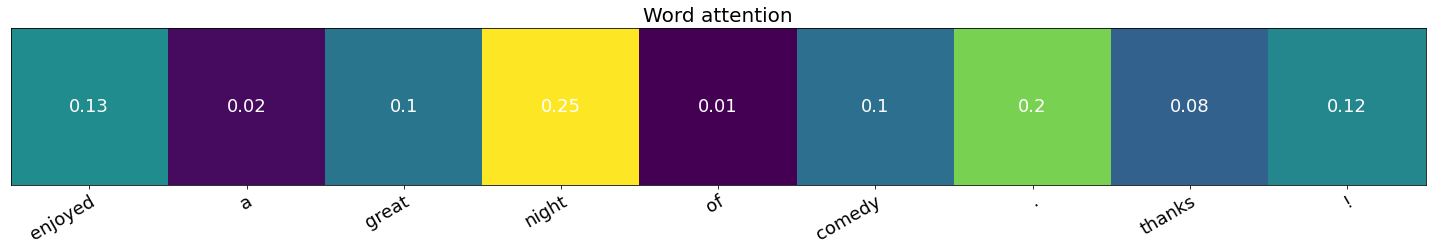

In [230]:
# Visualization of the flat attention

tokens = [wv.index2word[i] for i in features]

fig, ax = plt.subplots()
im = ax.imshow([model.word_attention.last_weights])
ax.set_xticks(range(len(tokens)))
ax.set_xticklabels((wv.index2word[f] for f in features), fontsize=18)
ax.set_title("Word attention", fontsize=20)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

# Add attention weight in each rectangle
for i in range(len(tokens)):
    ax.text(
        i,
        0,
        round(model.word_attention.last_weights[i], 2),
        fontsize=18,
        ha="center",
        va="center",
        color="w",
    )

# Remove y ticks
ax.yaxis.set_major_locator(plt.NullLocator())

fig.tight_layout()
# fig.savefig("visual_attn.pdf")